In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# 1. 环境与参数设置
# 设置中文字体，以正确显示图表中的中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 区块名称及其在DataFrame中对应的列名
LOCATIONS = {
    '西三旗': 'location_1',
    '清河': 'location_2',
    '西二旗': 'location_3',
    '上地': 'location_4'
}

# 2. 数据加载与预处理
# 从Excel文件中加载二手房和租房数据
try:
    df_esf = pd.read_excel('total_esf.xlsx')
    df_zu = pd.read_excel('total_zu.xlsx')
except FileNotFoundError:
    print("错误：请确保 'total_esf.xlsx' 和 'total_zu.xlsx' 文件在当前目录下。")
    exit()

# 计算单位面积的房价和租金
df_esf['price_per_m2'] = df_esf['total'] * 10000 / df_esf['square']
df_zu['rent_per_m2'] = df_zu['rent'] / df_zu['square']

#使用IQR（四分位距）方法检测并返回离群值的数量。
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return len(outliers)

#对单个区块进行完整的房价和租金分析。
def analyze_block(block_name, col_name, df_esf, df_zu):
    # 筛选出当前区块的数据
    esf_loc = df_esf[df_esf[col_name] == 1]['price_per_m2']
    zu_loc = df_zu[df_zu[col_name] == 1]['rent_per_m2']

    # 计算房价和租金的中位数
    median_price = esf_loc.median()
    median_rent = zu_loc.median()

    # 计算租售比（每月）
    price_to_rent_ratio = (median_price / median_rent) if median_rent > 0 else 0

    # 汇总统计结果
    result = {
        '区块': block_name,
        '房价样本数': len(esf_loc),
        '租金样本数': len(zu_loc),
        '房价中位数(元/m²)': median_price,
        '租金中位数(元/m²)': median_rent,
        '房价离群值数量': detect_outliers_iqr(esf_loc),
        '租金离群值数量': detect_outliers_iqr(zu_loc),
        '租售比(月)': price_to_rent_ratio
    }
    return result

# 4. 执行分析与生成结果
# 遍历所有区块，进行分析并将结果存入列表
analysis_results = [analyze_block(name, col, df_esf, df_zu) for name, col in LOCATIONS.items()]

# 将结果列表转换为DataFrame
summary_df = pd.DataFrame(analysis_results)

# 打印核心结果摘要表
pd.set_option('display.float_format', '{:.2f}'.format)
print(tabulate(summary_df, headers='keys', tablefmt='psql'))

+----+--------+--------------+--------------+---------------------+---------------------+------------------+------------------+--------------+
|    | 区块   |   房价样本数 |   租金样本数 |   房价中位数(元/m²) |   租金中位数(元/m²) |   房价离群值数量 |   租金离群值数量 |   租售比(月) |
|----+--------+--------------+--------------+---------------------+---------------------+------------------+------------------+--------------|
|  0 | 西三旗 |         1200 |         1100 |             56731.7 |             81.0559 |               18 |               80 |      699.909 |
|  1 | 清河   |         1200 |         1200 |             93720.7 |            100      |                0 |              104 |      937.207 |
|  2 | 西二旗 |          820 |          434 |             61379   |             96.9231 |                0 |               44 |      633.276 |
|  3 | 上地   |         1200 |         1016 |             86789.9 |            102.198  |               22 |               23 |      849.233 |
+----+--------+--------------+--------------+------

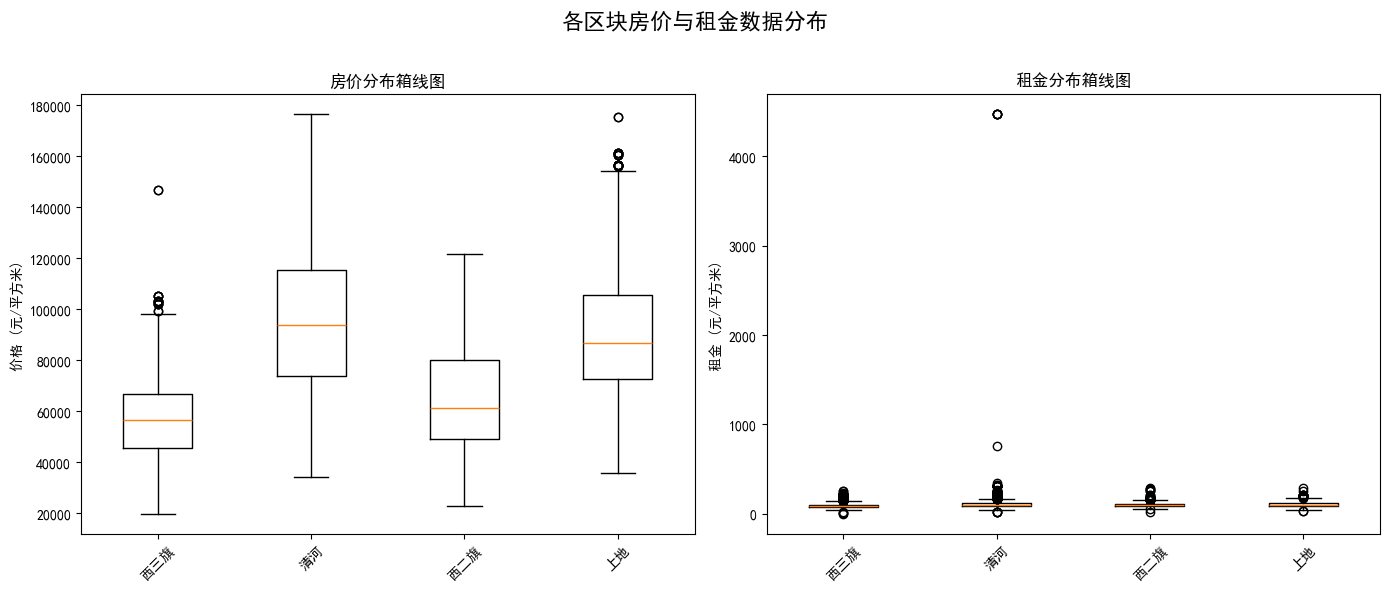

In [7]:
# 5. 数据可视化
# 5.1 绘制各区块房价与租金分布的箱线图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('各区块房价与租金数据分布', fontsize=16)

# 准备绘图数据
price_data_to_plot = [df_esf[df_esf[col] == 1]['price_per_m2'] for col in LOCATIONS.values()]
rent_data_to_plot = [df_zu[df_zu[col] == 1]['rent_per_m2'] for col in LOCATIONS.values()]
labels = LOCATIONS.keys()

# 绘制房价箱线图
ax1.boxplot(price_data_to_plot, tick_labels=labels)
ax1.set_title('房价分布箱线图')
ax1.set_ylabel('价格 (元/平方米)')
ax1.tick_params(axis='x', rotation=45)

# 绘制租金箱线图
ax2.boxplot(rent_data_to_plot, tick_labels=labels)
ax2.set_title('租金分布箱线图')
ax2.set_ylabel('租金 (元/平方米)')
ax2.tick_params(axis='x', rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('price_rent_distributions_boxplot.png', dpi=300)
plt.show()

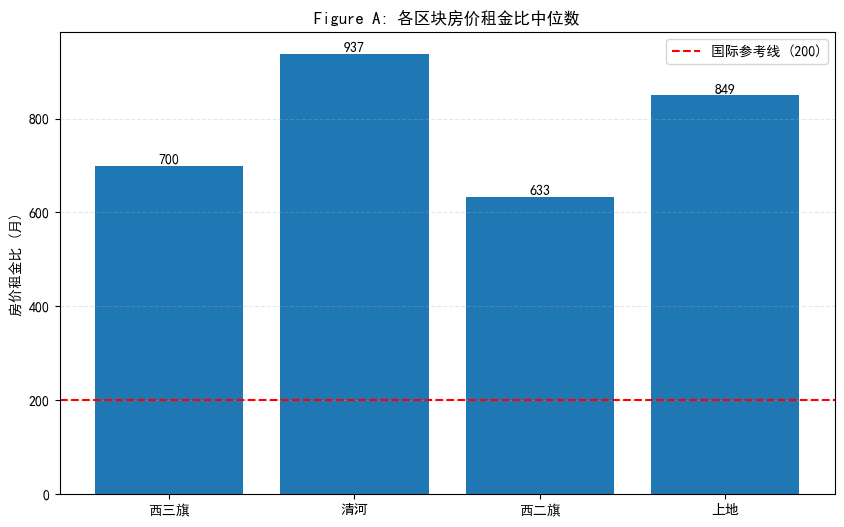

In [8]:
# 5.2 绘制房价租金比柱状图
plt.figure(figsize=(10, 6))
bars = plt.bar(summary_df['区块'], summary_df['租售比(月)'])

# 添加参考线
plt.axhline(y=200, color='red', linestyle='--', label='国际参考线 (200)')

# 在柱状图顶部显示数值
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.0f}', va='bottom', ha='center')

plt.ylabel('房价租金比 (月)')
plt.title('Figure A: 各区块房价租金比中位数')
plt.legend()
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.savefig('Figure_A_Price-to-Rent_Ratio.png', dpi=300)
plt.show()